In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import tensorflow as tf
from keras.backend.tensorflow_backend import set_session

config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
set_session(tf.Session(config=config))

%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from experiment_mnist import *
from experiment_constant import *
from experiment_random import *
from scipy.special import expit
import pandas as pd
import seaborn as sns
from helpers import *

Using TensorFlow backend.


In [2]:
# run with train dropout
#exp = MNISTExperiment([200, 200, 200, 100, 50], [p, 0, 0, 0, 0], 1, epochs = 100, activation = 'relu', reg_type = 0, do_print = True, train_dropout_l1 = p_train)

# run for regular MNIST
# exp = MNISTExperiment([200, 200, 200], [p, 0, 0], 1, epochs = 100, activation = 'relu', reg_type = 0, do_print = True)

# pfail at the first layer
# p = 0.01
#exp = MNISTExperiment([50, 50], [p, 0], 1, epochs = 50, activation = 'sigmoid', reg_type = 0, do_print = True)

### Fixed Random experiment

In [153]:
# pfailure for the first layer
p = 1e-2

In [154]:
# run with random weights and multiple inputs
exp = RandomExperiment([50, 50, 50, 50, 50, 1], [p, 0, 0, 0], 1, activation = 'relu', std_weight = 3, mean_weight = 0.1)

100%|██████████| 50/50 [00:04<00:00, 11.91it/s]


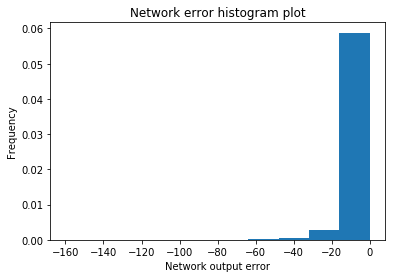

Absolute Error; average over inputs, average over dropout:
True values array mean: 266.039154 variance 329.647858
Bound L1Prod  8.556615
Bound L2Prod  2.869978
Bound L1Sum   29.399089
Bound L2Sum   20.926564
Bound FSum    24.055335
Bound v1      6.723552 Std 12.383179
Bound v2      2.636958
Bound v3 app  22.635049
Bound v3 exct 13.916465
Experiment    14.105806 Std 21.350725
MeanAct [0.38     0.963888 1.       1.      ]


In [168]:
# inputs to test
data = np.random.randn(50, 50) * 2

# obtaining data
r = exp.run(inputs = data, repetitions = 10000)

Only have v3_approx and v3_exact which support individual input vectors

In [257]:
# looking at output shapes
shapes = [[key, np.array(value).shape] for key, value in r.items()]
pd.DataFrame(shapes, columns = ['name', 'shape'])

,name,shape
0,input,"(50, 50)"
1,activations,"(50, 4)"
2,output,"(50, 1)"
3,error_exp_mean,"(50, 1)"
4,error_exp_std,"(50, 1)"
5,error_abs_exp_mean,"(50, 1)"
6,error_abs_exp_std,"(50, 1)"
7,error_v1_mean,()
8,error_v1_std,()
9,error_v2_mean,"(1,)"


In [261]:
# creating a dataframe with exp, v3.exact, v3.approx
data = {}
data['exp.mean'] = r['error_exp_mean'].flatten()
data['v3.exact'] = r['error_v3_mean_exact'].flatten()
data['v3.approx'] = r['error_v3_mean_approx'].flatten()
data = pd.DataFrame(data)

           exp.mean  v3.exact  v3.approx
exp.mean   1.000000  0.999868   0.849838
v3.exact   0.999868  1.000000   0.851523
v3.approx  0.849838  0.851523   1.000000
{'v3.exact': 0.013877551020408163, 'v3.approx': 0.053061224489795916}


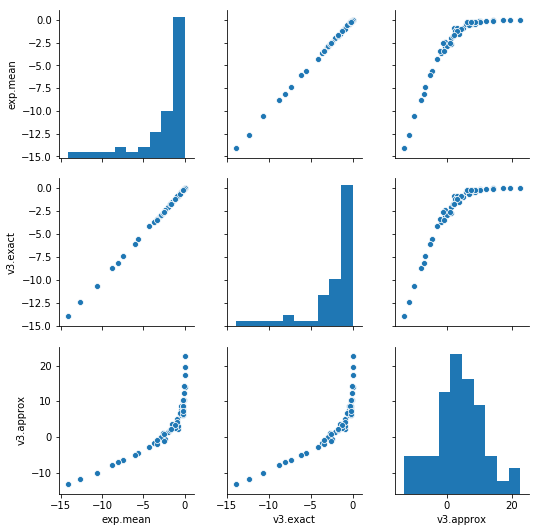

In [262]:
# pairwise plots
sns.pairplot(data)

# printing correlation
print(data.corr())

# printing ranking loss
print(compute_rank_losses(data, 'exp.mean'))

See that there's correlation of approximately 0.999... between theory (v3.exact) and practive (experiment, mean over repetitions). Same is not true for the approximate bound which gives somethins about 0.90. Again, exact bound is better in rank loss

### Comparing random networks on a fixed input

In [2]:
# pfailure for the first layer
p = 1e-2

# input to test
data = np.random.randn(1, 50) * 2 + 0.1

In [4]:
# array with networks
results = []

# looking at 50 random networks
for i in tqdm(range(100)):
    # run with random weights and multiple inputs
    exp = RandomExperiment([50, 50, 50, 1], [p, 0], 1, activation = 'relu', std_weight = 3, mean_weight = 0.1)

    # obtaining data
    r = exp.run(inputs = data, repetitions = 10000, do_plot = False, do_tqdm = False, do_print = False)
    
    # adding to results
    results += [r]
    
    # removing the model
    K.clear_session()

100%|██████████| 100/100 [00:25<00:00,  4.09it/s]


In [5]:
# creating a dataframe with exp, v3.exact, v3.approx
data = {}

# loop over networks
for net in results:
    for key, value in net.items():
        if key not in data: data[key] = []
        data[key] += [np.mean(value)]

del data['input']
del data['error_exp_std']
del data['error_abs_exp_std']
del data['error_v1_std']

data = pd.DataFrame(data)

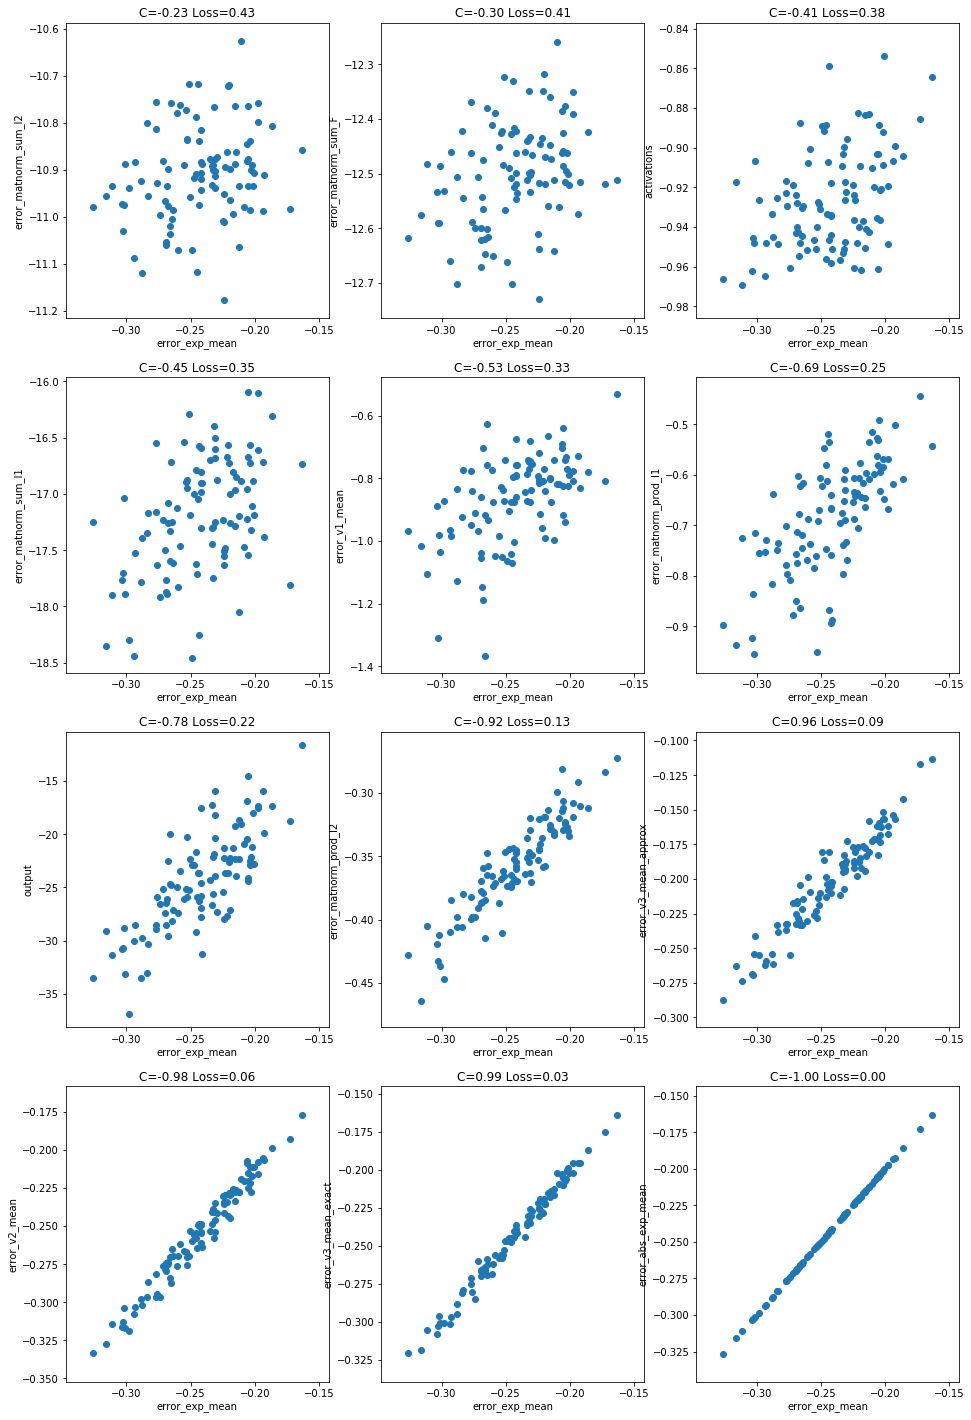

In [19]:
# plotting scatter plots with experimental mean
main_key = 'error_exp_mean'
corr = data.corr()[main_key]
loss = {x: min(y, 1 - y) for x, y in compute_rank_losses(data, main_key).items()}
other_keys = [key for key in data.keys() if key != main_key]
other_keys = sorted(other_keys, key = lambda key: np.abs(corr[key]))
fig, axs = plt.subplots(4, 3, figsize=(16, 25))
axs = axs.ravel()
for i, key in enumerate(other_keys):
    axs[i].set_title('C=%.2f Loss=%.2f' % (corr[key], loss[key]))
    axs[i].set_xlabel(main_key)
    axs[i].set_ylabel(key)
    axs[i].scatter(data[main_key], data[key] * np.sign(corr[key]))

In [20]:
# List the best bounds
pd.DataFrame([(key, corr[key], loss[key]) for key in other_keys[::-1]], columns = ['value', 'Correlation', 'Rank Loss'])

,value,Correlation,Rank Loss
0,error_abs_exp_mean,-1.000000,0.000000
1,error_v3_mean_exact,0.993324,0.033131
2,error_v2_mean,-0.983805,0.057374
3,error_v3_mean_approx,0.958917,0.089293
4,error_matnorm_prod_l2,-0.919463,0.125657
5,output,-0.777466,0.216768
6,error_matnorm_prod_l1,-0.690333,0.247677
7,error_v1_mean,-0.530639,0.326465
8,error_matnorm_sum_l1,-0.451506,0.350303
9,activations,-0.409300,0.376970
